In [1]:
import os
import torch
import torchvision.transforms as T

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from matplotlib.image import imread

import numpy as np 

from sklearn.decomposition import PCA

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def get_model():
    dinov2_vitb14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14')
    return dinov2_vitb14


def get_image(path): # returns torch.tesnor
    # get image corresponding to path
    img = imread(path)
    
    if img.shape[-1] != 3:
        return
    # initialize transformations for images
    transform = T.Compose([
        T.ToTensor(),
        T.Resize((224, 224)),
        T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),])
    
    # apply transformations to image
    img = transform(img)[:3].unsqueeze(0)

    return img


def get_dataset(cat_img_path, dog_imgs_path, number_of_images_per_class): # returns torch.tensor for images
    images = []                                                           # returns numpy.ndarray for labels
    labels = []
    image_names = [] # Added line
    cat_img_names = os.listdir(cat_img_path)
    np.random.shuffle(cat_img_names)
    
    for name in cat_img_names[:number_of_images_per_class]:
        img_path = os.path.join(cat_img_path, name)
        extension = img_path.split('.')[-1]
        if extension != 'db':
            tmp_img = get_image(img_path)
            if tmp_img is not None:
                images.append(tmp_img)
                labels.append(torch.tensor(0))
                image_names.append(name)  # Added line
    
    dog_img_names = os.listdir(dog_imgs_path)
    np.random.shuffle(dog_img_names)
    for name in dog_img_names[:number_of_images_per_class]:
        img_path = os.path.join(dog_imgs_path, name)
        extension = img_path.split('.')[-1]
        if extension != 'db':
            tmp_img = get_image(img_path)
            if tmp_img is not None:
                images.append(tmp_img)
                labels.append(torch.tensor(1))
                image_names.append(name)  # Added line
    
    images = torch.cat(images, dim=0)
    labels = np.array(labels)
    
    return images, labels, image_names 


def get_image_features(model, images): # returns numpy.ndarray
    model.eval()
    features = []
    for img in tqdm(images):
        with torch.no_grad():
            x = model.prepare_tokens_with_masks(img.unsqueeze(0))
            for i, blk in enumerate(model.blocks):
                x = blk(x)
            x = model.norm(x)
            
            img_features = x[:, 0, :]
            features.append(img_features)
    features = torch.cat(features, dim=0)
    print()
    return features.detach().numpy()


def get_patch_features(model, images): # returns numpy.ndarray
    model.eval()
    features = []
    for img in tqdm(images):
        with torch.no_grad():
            x = model.prepare_tokens_with_masks(img)
            for i, blk in enumerate(model.blocks):
                x = blk(x)
            x = model.norm(x)
            
            patch_features = x[:, 1:, :]
            features.append(img_features)
    features = torch.cat(features, dim=0)
    return features.detach().numpy()

In [5]:
images, labels, image_names = get_dataset(r"/content/drive/MyDrive/images/Cat", r"/content/drive/MyDrive/images/Dog", 1000)
model = get_model()

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitb14/dinov2_vitb14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vitb14_pretrain.pth
100%|██████████| 330

In [6]:
img_features = get_image_features(model, images)

  0%|          | 0/1995 [00:00<?, ?it/s]

In [65]:
print("Number of dog images:", np.count_nonzero(labels == 1))
print("Number of cat images:", np.count_nonzero(labels == 0))

Number of dog images: 996
Number of cat images: 999


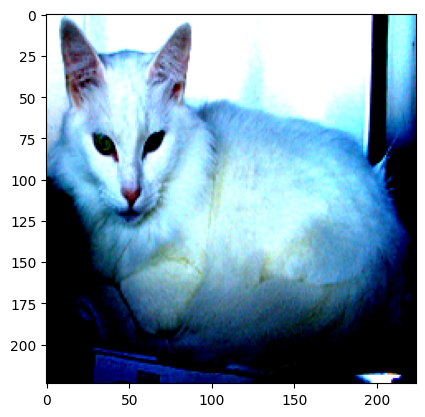

In [15]:
plt.imshow(images[125].permute(1, 2, 0))

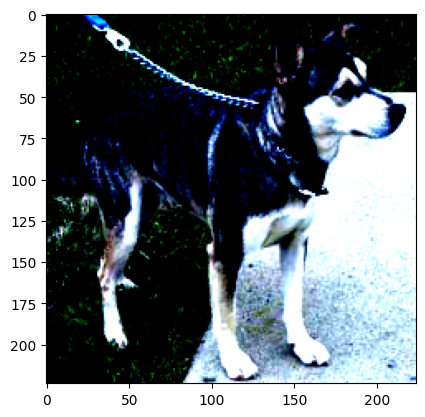

In [14]:
plt.imshow(images[1311].permute(1, 2, 0))

# 1

1. Using vector representation of images (see get_image_features function) with PCA and t-SNE dimensionality reduction algorithms visualize those vectors in 2D dimension, according to their classification.

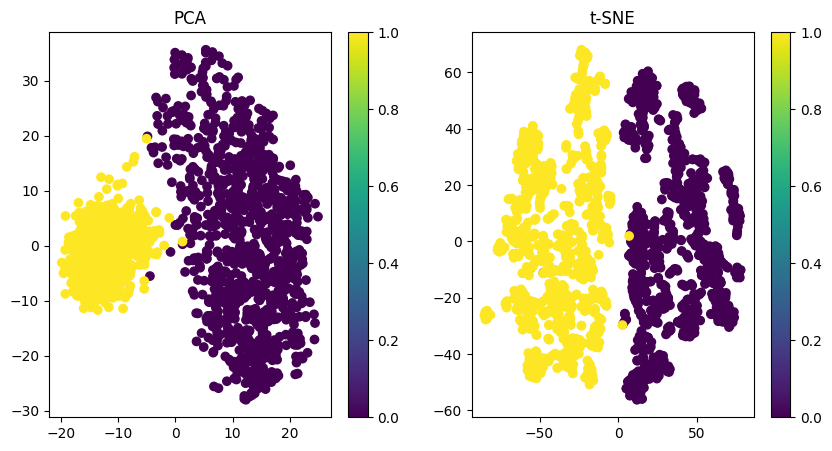

In [16]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Perform PCA dimensionality reduction
pca = PCA(n_components=2)
pca_result = pca.fit_transform(img_features[:len(images)])

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, perplexity=10)
tsne_result = tsne.fit_transform(img_features[:len(images)])

# Plot PCA results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels[:len(images)])
plt.title('PCA')
plt.colorbar()

# Plot t-SNE results
plt.subplot(1, 2, 2)
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels[:len(images)])
plt.title('t-SNE')
plt.colorbar()


# 2

2. Using vector representation of images solve the classification problem with KNN, Logistic Regression and SVM.

In [47]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold

In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(img_features, labels, test_size=0.2, random_state=42)

In [57]:
# Set up KNN model
k = 5  # number of neighbors
model = KNeighborsClassifier(n_neighbors=k)

# Set up cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
scores = cross_val_score(model, X_train, y_train, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores for k-NN:", scores)
print("Mean score for k-NN:", scores.mean())

Cross-validation scores for k-NN: [1.        0.9968652 1.        0.9968652 1.       ]
Mean score for k-NN: 0.9987460815047022


In [58]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
knn_predictions = knn.predict(X_test)
knn_test_accuracy = accuracy_score(y_test, knn_predictions)

print("k-NN Accuracy (Test Set):", knn_test_accuracy)

k-NN Accuracy (Test Set): 0.9974937343358395


In [59]:
# Set up your Logistic Regression model with regularization
model = LogisticRegressionCV(cv=5, random_state=42)

# Set up cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
scores = cross_val_score(model, X_train, y_train, cv=kfold)

# Print the cross-validation scores
print("Cross-validation scores for Logistic Regression:", scores)
print("Mean score for Logistic Regression:", scores.mean())

Cross-validation scores for Logistic Regression: [1.         0.99373041 1.         1.         1.        ]
Mean score for Logistic Regression: 0.9987460815047022


In [60]:
logreg = LogisticRegression(C=1.0, penalty='l2')
logreg.fit(X_train, y_train)
logreg_predictions = logreg.predict(X_test)
logreg_test_accuracy = accuracy_score(y_test, logreg_predictions)

print("Logistic Regression Accuracy (Test Set):", logreg_test_accuracy)

Logistic Regression Accuracy (Test Set): 0.9974937343358395


In [61]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Set up your SVM model with RBF kernel
model = SVC(kernel='linear')

# Set up regularization parameter values to try
param_grid = {'C': [0.1, 1, 10], 'gamma': [0.1, 1, 10]}

# Set up grid search with cross-validation
grid_search = GridSearchCV(model, param_grid, cv=5)

# Perform grid search with cross-validation
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best parameters for SVM linear kernel:", grid_search.best_params_)

# Print the best cross-validation score
print("Best cross-validation score for SVM linear kernel:", grid_search.best_score_)
print()

Best parameters for SVM linear kernel: {'C': 0.1, 'gamma': 0.1}
Best cross-validation score for SVM linear kernel: 0.9987460815047022



In [64]:
svm = SVC(kernel='linear', C=0.1, gamma=0.1)
svm.fit(X_train, y_train)
svm_predictions = svm.predict(X_test)
svm_test_accuracy = accuracy_score(y_test, svm_predictions)

print("SVM Accuracy (Test Set):", svm_test_accuracy)

SVM Accuracy (Test Set): 0.9974937343358395


# 3

3. Compare the above algorithms using different metrics(Accuracy, F1 Score). For models like LR and SVM, also count AUC and draw the ROC curve

auc_lr:  0.999823987930601
auc_svm:  0.9997988433492583


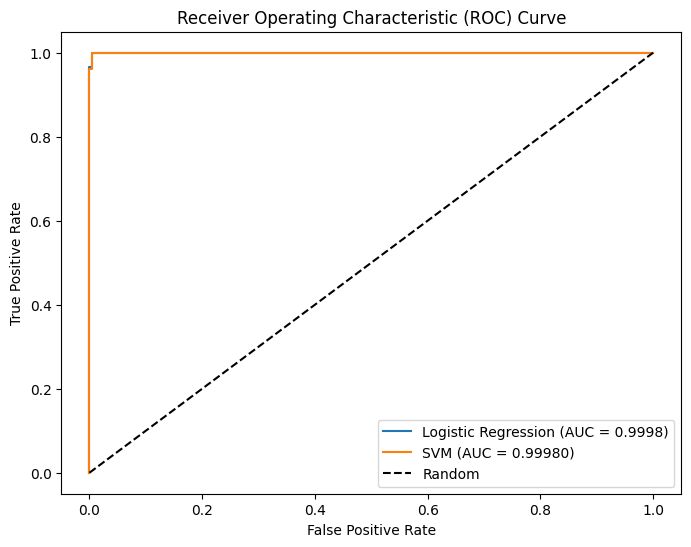

k-NN Accuracy: 0.9974937343358395
k-NN F1 Score: 0.9975669099756691
Logistic Regression Accuracy: 0.9974937343358395
Logistic Regression F1 Score: 0.9975669099756691
SVM Accuracy: 0.9974937343358395
SVM F1 Score: 0.9975669099756691


In [18]:
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt

# evaluate k-NN
knn_predictions = knn.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_predictions)
knn_f1_score = f1_score(y_test, knn_predictions)

# evaluate Logistic Regression
logreg_predictions = logreg.predict(X_test)
logreg_accuracy = accuracy_score(y_test, logreg_predictions)
logreg_f1_score = f1_score(y_test, logreg_predictions)
logreg_probabilities = logreg.predict_proba(X_test)[:, 1]

# evaluate SVM
svm_predictions = svm.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_predictions)
svm_f1_score = f1_score(y_test, svm_predictions)
svm_probabilities = svm.predict_proba(X_test)[:, 1]

# Calculate and plot ROC curve for LR
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_test, logreg_probabilities)
auc_lr = auc(fpr_lr, tpr_lr)
print('auc_lr: ', auc_lr)

# Calculate and plot ROC curve for SVM
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, svm_probabilities)
auc_svm = auc(fpr_svm, tpr_svm)
print('auc_svm: ', auc_svm)


# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, label='Logistic Regression (AUC = {:.4f})'.format(auc_lr))
plt.plot(fpr_svm, tpr_svm, label='SVM (AUC = {:.5f})'.format(auc_svm))
plt.plot([0, 1], [0, 1], linestyle='--', color='black', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Print the evaluation metrics
print("k-NN Accuracy:", knn_accuracy)
print("k-NN F1 Score:", knn_f1_score)
print("Logistic Regression Accuracy:", logreg_accuracy)
print("Logistic Regression F1 Score:", logreg_f1_score)
print("SVM Accuracy:", svm_accuracy)
print("SVM F1 Score:", svm_f1_score)

# 4

4. Using patch features (see get_patch_features - function): for a few images reproduce the results of the DINOv2 article into PCA by application.

In [19]:
import requests
from PIL import Image
from torchvision import transforms
transform = transforms.Compose([           
                                transforms.Resize(256),                    
                                transforms.CenterCrop(224),               
                                transforms.ToTensor(),                    
                                transforms.Normalize(                      
                                mean=[0.485, 0.456, 0.406],                
                                std=[0.229, 0.224, 0.225]              
                                )])


transform1 = transforms.Compose([           
                                transforms.Resize(520),
                                transforms.CenterCrop(518), #should be multiple of model patch_size                 
                                transforms.ToTensor(),                    
                                transforms.Normalize(mean=0.5, std=0.2)
                                ])

In [40]:
patch_size = model.patch_size # patchsize=14

patch_h  = 520//patch_size
patch_w  = 520//patch_size

feat_dim = 768 # features dimension

folder_path = r"/content/drive/MyDrive/images/Cat"
total_features  = []
with torch.no_grad():
  for img_path in tqdm(os.listdir(folder_path)[:10]):
    img_path = os.path.join(folder_path, img_path)
    img = Image.open(img_path).convert('RGB')
    img_t = transform1(img)
    
    features_dict = model.forward_features(img_t.unsqueeze(0))
    features = features_dict['x_norm_patchtokens']
    total_features.append(features)

total_features = torch.cat(total_features, dim=0)
total_features.shape

  0%|          | 0/10 [00:00<?, ?it/s]

torch.Size([10, 1369, 768])

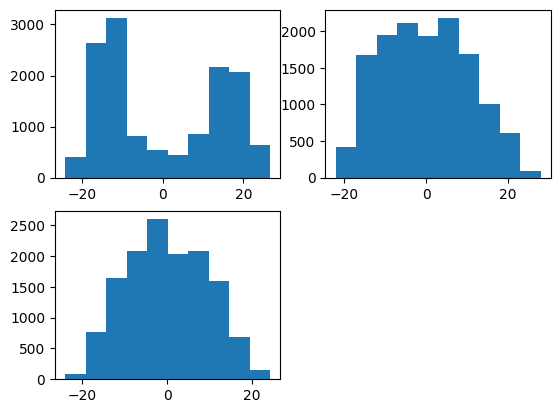

In [41]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# First PCA to Separate Background
# Reshape total_features
total_features = total_features.reshape(10 * patch_h * patch_w, feat_dim)

pca = PCA(n_components=3)
pca.fit(total_features)
pca_features = pca.transform(total_features)

# Visualize PCA components for finding a proper threshold
plt.subplot(2, 2, 1)
plt.hist(pca_features[:, 0])
plt.subplot(2, 2, 2)
plt.hist(pca_features[:, 1])
plt.subplot(2, 2, 3)
plt.hist(pca_features[:, 2])
plt.show()
plt.close()

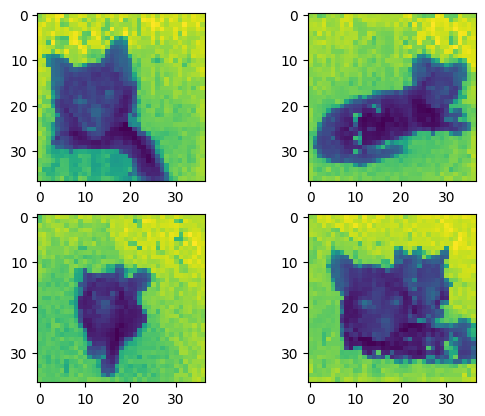

In [42]:
# Reverse min-max scale
pca_features[:, 0] = 1 - ((pca_features[:, 0] - pca_features[:, 0].min()) / 
                         (pca_features[:, 0].max() - pca_features[:, 0].min()))

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features[i*patch_h*patch_w : (i+1)*patch_h*patch_w, 0].reshape(patch_h, patch_w))

plt.show()

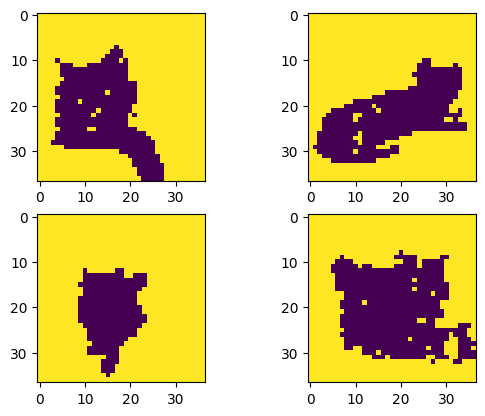

In [43]:
# segment/seperate the backgound and foreground using the first component
pca_features_bg = pca_features[:, 0] > 0.35 # from first histogram
pca_features_fg = ~pca_features_bg

# plot the pca_features_bg
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features_bg[i * patch_h * patch_w: (i+1) * patch_h * patch_w].reshape(patch_h, patch_w))
plt.show()

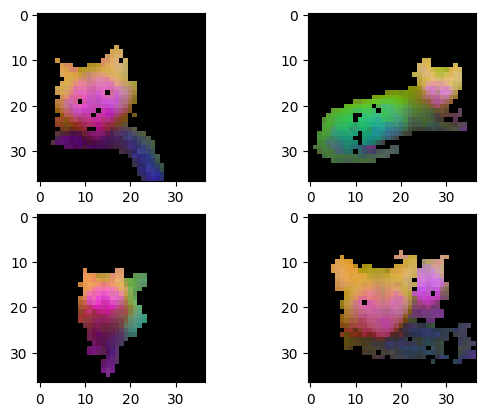

In [44]:
# 2nd PCA for only foreground patches
pca.fit(total_features[pca_features_fg]) 
pca_features_left = pca.transform(total_features[pca_features_fg])

for i in range(3):
    # min_max scaling
    pca_features_left[:, i] = (pca_features_left[:, i] - pca_features_left[:, i].min()) / (pca_features_left[:, i].max() - pca_features_left[:, i].min())

pca_features_rgb = pca_features.copy()
# for black background
pca_features_rgb[pca_features_bg] = 0
# new scaled foreground features
pca_features_rgb[pca_features_fg] = pca_features_left

# reshaping to numpy image format
# Ensure the size of pca_features_rgb matches the desired shape
num_patches = 4
pca_features_rgb = pca_features_rgb[:num_patches * patch_h * patch_w, :]  # Truncate the array if needed
pca_features_rgb = pca_features_rgb.reshape(num_patches, patch_h, patch_w, 3)

for i in range(num_patches):
    plt.subplot(2, 2, i+1)
    plt.imshow(pca_features_rgb[i])

plt.show()